<a href="https://colab.research.google.com/github/gaixen/BCS_recruitment/blob/main/Mission%20Synaptech%3A%20Save%20Dr.%20Z%E2%80%99s%20Mind/demo-solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
pip install brian2

# Cortical Microcircuit Simulation in Brian2
Simulates a simplified cortical microcircuit with excitatory and inhibitory neurons, STDP, and external input.

In [29]:
from brian2 import *

# Set simulation units
start_scope()
duration = 500*ms  # Total time

In [30]:
# Izhikevich model equations and parameters
a_e, b_e, c_e, d_e = 0.02/ms, 0.2/ms, -65*mV, 8*mV/ms
a_i, b_i, c_i, d_i = 0.1/ms, 0.2/ms, -65*mV, 2*mV/ms

eqs = '''
dv/dt = (0.04/ms/mV)*v**2 + 5/ms*v + 140*mV/ms - u + I : volt
du/dt = a*(b*v - u) : volt/second
I : volt/second
a : 1/second
b : 1/second
c : volt
d : volt/second
'''


In [31]:
# Create neuron groups
N = 100
Ne = int(0.8 * N)
Ni = N - Ne

reset = '''
v = c
u += d
'''

neurons = NeuronGroup(N, model=eqs, threshold='v > 30*mV',
                      reset=reset, method='euler')



# Initialize neurons
neurons.v = -65*mV
neurons.u = neurons.b * neurons.v
neurons.I = 5*mV/ms


# Assign parameters for excitatory and inhibitory neurons
neurons.a[:Ne] = a_e
neurons.b[:Ne] = b_e
neurons.c[:Ne] = c_e
neurons.d[:Ne] = d_e

neurons.a[Ne:] = a_i
neurons.b[Ne:] = b_i
neurons.c[Ne:] = c_i
neurons.d[Ne:] = d_i

In [32]:
# Define STDP synapses (excitatory to all)
stdp_eqs = '''
w : 1
dApre/dt = -Apre / tau_pre : 1 (event-driven)
dApost/dt = -Apost / tau_post : 1 (event-driven)
'''

on_pre = '''
v_post += w*mV
Apre += dApre
w = clip(w + Apost, 0, wmax)
'''

on_post = '''
Apost += dApost
w = clip(w + Apre, 0, wmax)
'''

tau_pre = 20*ms
tau_post = 20*ms
dApre = 0.01
dApost = -dApre * 1.05
wmax = 1.0

syn_ee = Synapses(neurons[:Ne], neurons, model=stdp_eqs, on_pre=on_pre, on_post=on_post)
syn_ee.connect(p=0.1)
syn_ee.w = '0.5 + 0.1*rand()'

In [33]:
# Inhibitory to excitatory synapses
syn_ie = Synapses(neurons[Ne:], neurons[:Ne], on_pre='v_post -= 1*mV')
syn_ie.connect(p=0.3)

In [34]:
# External input (Poisson group)
stim = PoissonGroup(20, rates=10*Hz)
input_syn = Synapses(stim, neurons[:Ne], on_pre='v_post += 2*mV')

input_syn.connect(p=0.5)

In [35]:
# Monitors
spike_mon = SpikeMonitor(neurons)
volt_mon = StateMonitor(neurons, 'v', record=range(5))

In [36]:
# Run simulation
run(duration)

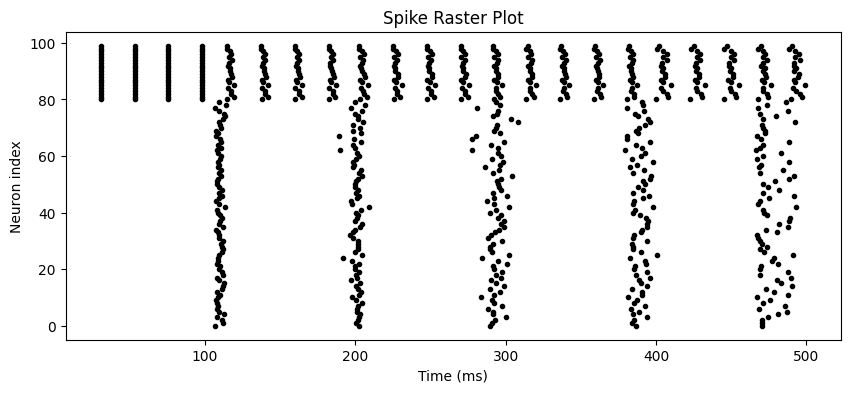

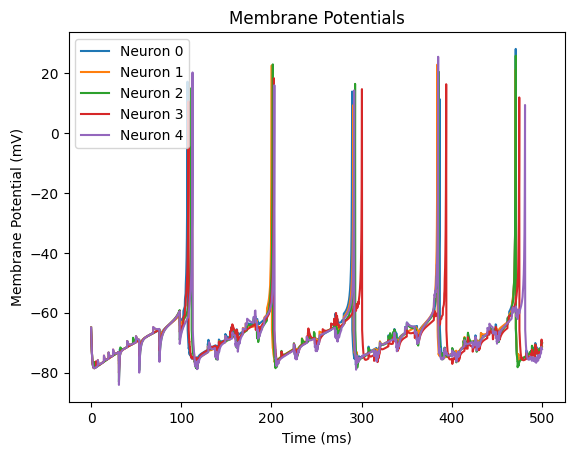

In [37]:
# Plot results
figure(figsize=(10,4))
plot(spike_mon.t/ms, spike_mon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
title('Spike Raster Plot')
show()

figure()
for i in range(5):
    plot(volt_mon.t/ms, volt_mon.v[i]/mV, label=f'Neuron {i}')
xlabel('Time (ms)')
ylabel('Membrane Potential (mV)')
legend()
title('Membrane Potentials')
show()